#**Autoencoder Model for Word Embedding**

#I. Import necessary things

In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import re
import os
import pickle
import nltk
import numpy as np
from scipy.spatial import distance

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#II. Load corpus and preprocess it

In [2]:
!gdown 1GEKvtsfNAEKuYi69GIxKmIhTq_dFautM

Downloading...
From: https://drive.google.com/uc?id=1GEKvtsfNAEKuYi69GIxKmIhTq_dFautM
To: /content/emotion_ds.csv
100% 222k/222k [00:00<00:00, 10.7MB/s]


In [7]:
# Load data
def load_data(csv_file):
    return pd.read_csv(csv_file, encoding="latin")

train_data = load_data("/content/emotion_ds.csv").iloc[:2000]

corpus = train_data["text"].to_list()
corpus = "\n".join(corpus)
print(corpus[:1000])

i hadn t seen for two years spending a sun filled day at the aussie open followed by dumplings at chinatown and a lemonade in a leafy beer garden feeling like i had stepped back in time at labour in vain on brunswick street attending a backyard barbecue and visiting edinburgh gardens for aussie day
i like to add a slice of cheese and some pepper to the egg and when i am feeling naughty i like to add some chocolate chips to my trail mix another treat i am loving as a pregnant mom who often craves a sweet but doesn t want to overload on sugar or empty calories is zico coconut water in chocolate
i have these bunch of friends im grateful to have the squad mates and the teammates but theres another bunch of people out there that made me feel so worthless because everything i try to do with them it seems so forced conversations it seems like i am forcing my words on them and everything else
i also feel devoted to my profession because i get ever so annoyed when i see things that would advers

In [8]:
def text_cleaner(text):
    # lower case text
    text = text.lower()
    text = re.sub(r"'s\b","",text)
    # remove punctuations
    text = re.sub("[^a-zA-Z]", " ", text)
    return text

In [9]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def preprocess_text(corpus):
  corpus_clean = text_cleaner(corpus)

  stop_words = set(stopwords.words('english'))
  word_tokens = word_tokenize(corpus_clean)

  return [w for w in word_tokens if not w in stop_words]

corpus_token =  preprocess_text(corpus)
print(corpus_token)

['seen', 'two', 'years', 'spending', 'sun', 'filled', 'day', 'aussie', 'open', 'followed', 'dumplings', 'chinatown', 'lemonade', 'leafy', 'beer', 'garden', 'feeling', 'like', 'stepped', 'back', 'time', 'labour', 'vain', 'brunswick', 'street', 'attending', 'backyard', 'barbecue', 'visiting', 'edinburgh', 'gardens', 'aussie', 'day', 'like', 'add', 'slice', 'cheese', 'pepper', 'egg', 'feeling', 'naughty', 'like', 'add', 'chocolate', 'chips', 'trail', 'mix', 'another', 'treat', 'loving', 'pregnant', 'mom', 'often', 'craves', 'sweet', 'want', 'overload', 'sugar', 'empty', 'calories', 'zico', 'coconut', 'water', 'chocolate', 'bunch', 'friends', 'im', 'grateful', 'squad', 'mates', 'teammates', 'theres', 'another', 'bunch', 'people', 'made', 'feel', 'worthless', 'everything', 'try', 'seems', 'forced', 'conversations', 'seems', 'like', 'forcing', 'words', 'everything', 'else', 'also', 'feel', 'devoted', 'profession', 'get', 'ever', 'annoyed', 'see', 'things', 'would', 'adversely', 'bring', 'adv

In [10]:
dictionary = sorted(list(set(corpus_token)))

if os.path.exists("mapping.pkl"):
  print("Load mapping")
  mapping = pickle.load(open("mapping.pkl", "rb"))
else:
  print("Save mapping")
  mapping = dict((c, i) for i, c in enumerate(dictionary))
  pickle.dump(mapping, open("mapping.pkl", "wb"))

print(dictionary)

Load mapping
['aahhh', 'abandoned', 'abc', 'abdomen', 'abducted', 'abilities', 'ability', 'abit', 'able', 'aboard', 'absolute', 'absolutely', 'abundantly', 'abuse', 'abused', 'abusive', 'academic', 'accept', 'acceptance', 'accepted', 'accepting', 'accident', 'accidentally', 'accompany', 'accomplishment', 'accomplishments', 'accord', 'according', 'accrue', 'accurately', 'accustomed', 'ache', 'aches', 'achieve', 'achieved', 'achieving', 'aching', 'acknowledge', 'acne', 'across', 'act', 'acted', 'acting', 'action', 'actions', 'active', 'actively', 'activities', 'actors', 'acts', 'actual', 'actually', 'acumen', 'acutely', 'add', 'addiction', 'addition', 'address', 'addressed', 'admire', 'admired', 'admiring', 'admit', 'adolescence', 'adore', 'adoring', 'adults', 'advances', 'adventure', 'adversary', 'adverse', 'adversely', 'advertisements', 'advertises', 'advertising', 'advice', 'advise', 'aesthetics', 'affect', 'affected', 'affectionate', 'affirmation', 'affirmations', 'affirmed', 'afford

#III. Convert corpus to one-hot vectors & Define embedding dim

In [11]:
embedding_dim = 256
vocab_size = len(dictionary)
print(vocab_size)

5258


In [12]:
corpus_encode = [mapping[x] for x in corpus_token]
onehot_corpus = keras.utils.to_categorical(corpus_encode, num_classes=vocab_size)
print(onehot_corpus)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#IV. Define Autoencoder model

In [13]:
ae_model = keras.Sequential()
ae_model.add(keras.Input(shape=(vocab_size,)))
ae_model.add(keras.layers.Dense(embedding_dim, activation='relu'))
ae_model.add(keras.layers.Dense(vocab_size, activation='softmax'))

ae_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

if os.path.exists("ae_model.h5"):
  ae_model.load_weights("ae_model.h5")

ae_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1346304   
                                                                 
 dense_1 (Dense)             (None, 5258)              1351306   
                                                                 
Total params: 2697610 (10.29 MB)
Trainable params: 2697610 (10.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#V. Train AE model

In [12]:
# Train model
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("ae_model.h5", monitor='val_loss', save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

ae_model.fit(x=onehot_corpus, y=onehot_corpus, batch_size=512, epochs=1000,
          validation_split=0.2, validation_freq=1, shuffle=True,
          callbacks=[checkpoint_cb, early_stopping_cb],
          workers=1, use_multiprocessing=False)

ae_model.save("ae_model.h5")

Epoch 1/1000
31/31 [==============================] - 3s 44ms/step - loss: 8.4985 - accuracy: 0.3285 - val_loss: 8.3514 - val_accuracy: 0.3633
Epoch 2/1000
 4/31 [==>...........................] - ETA: 0s - loss: 8.3165 - accuracy: 0.3281

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 1s 25ms/step - loss: 8.0280 - accuracy: 0.2246 - val_loss: 7.5965 - val_accuracy: 0.1701
Epoch 3/1000
31/31 [==============================] - 1s 23ms/step - loss: 7.0791 - accuracy: 0.0904 - val_loss: 6.7566 - val_accuracy: 0.1083
Epoch 4/1000
31/31 [==============================] - 1s 23ms/step - loss: 6.4051 - accuracy: 0.0483 - val_loss: 6.3231 - val_accuracy: 0.0621
Epoch 5/1000
31/31 [==============================] - 1s 23ms/step - loss: 5.8878 - accuracy: 0.0935 - val_loss: 5.8818 - val_accuracy: 0.2350
Epoch 6/1000
31/31 [==============================] - 1s 22ms/step - loss: 5.3132 - accuracy: 0.2719 - val_loss: 5.3890 - val_accuracy: 0.3715
Epoch 7/1000
31/31 [==============================] - 1s 24ms/step - loss: 4.6933 - accuracy: 0.4185 - val_loss: 4.8785 - val_accuracy: 0.5051
Epoch 8/1000
31/31 [==============================] - 1s 35ms/step - loss: 4.0962 - accuracy: 0.5257 - val_loss: 4.4393 - val_accuracy: 0.5728
Epoch 9/1000

#=======================================================================

# **How to use trained model**

#=======================================================================

#VI. Load trained model & Get output of 1st FC layer

In [3]:
!gdown 1JOFDnMjdZBpdjsg_vJXMbfsMM-IhCWK9
!gdown 135K7MUAsnYYoel9OnU0CaEQsLeU1SUoT

Downloading...
From: https://drive.google.com/uc?id=1JOFDnMjdZBpdjsg_vJXMbfsMM-IhCWK9
To: /content/ae_model.h5
100% 32.4M/32.4M [00:00<00:00, 54.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=135K7MUAsnYYoel9OnU0CaEQsLeU1SUoT
To: /content/mapping.pkl
100% 67.0k/67.0k [00:00<00:00, 2.92MB/s]


In [14]:
reconstructed_model = keras.models.load_model("ae_model.h5")
we_model = keras.models.Model(inputs=reconstructed_model.inputs, outputs=reconstructed_model.get_layer('dense').output)

Define function to encode one-hot list of words

In [15]:
def encode_onehot(mapping, list_words):
  output = []

  for word in list_words:
    word_vector = [0 for _ in range(vocab_size)]

    if word in mapping.keys():
      word_index = mapping[word]
      word_vector[word_index] = 1

    output.append(word_vector)

  return output

#VII. Test model

In [19]:
input_sentence = "i have a lot of missing information about how your previous final communication went and how you feel about this guy and what you ever liked about him but i will advise you to not be afraid of him in any way if you don t want to communicate further with him just tell him that"

preprocess_sentence = preprocess_text(input_sentence)
onehot_sentence = encode_onehot(mapping, preprocess_sentence)

embedded_sentence = we_model.predict(onehot_sentence)
embedded_sentence

1/1 [==============================] - 0s 29ms/step


array([[2.102882 , 2.1547966, 2.1006532, ..., 1.4139782, 2.1351314,
        2.0380812],
       [2.0441961, 2.0280716, 2.0310655, ..., 2.2179036, 2.0367079,
        2.0179422],
       [2.0396538, 2.0866446, 2.0880554, ..., 1.5610763, 2.0532818,
        2.0227807],
       ...,
       [2.1398926, 1.9863057, 2.1825788, ..., 2.2164464, 2.0855427,
        2.1057808],
       [1.3963245, 1.4400783, 2.0860157, ..., 2.2585707, 1.3467228,
        1.3587259],
       [2.0445728, 1.4066814, 1.3895781, ..., 1.5373199, 1.366566 ,
        2.0567636]], dtype=float32)

In [20]:
word_0 = "people"
word_1 = "feeling"
word_2 = "life"

preprocess_words = preprocess_text(' '.join([word_0, word_1, word_2]))
onehot_words = encode_onehot(mapping, preprocess_words)

word_0_eb, word_1_eb, word_2_eb = we_model.predict(onehot_words)

# print("OUTPUT EMBEDDING")
# print(word_0_eb)
# print(word_1_eb)
# print(word_2_eb)

dst_0_1 = distance.euclidean(word_0_eb, word_1_eb)
dst_1_2 = distance.euclidean(word_1_eb, word_2_eb)
dst_2_0 = distance.euclidean(word_2_eb, word_0_eb)

print("OUTPUT DISTANCE")
print("0 vs 1: ", dst_0_1)
print("1 vs 2: ", dst_1_2)
print("2 vs 0: ", dst_2_0)

1/1 [==============================] - 0s 29ms/step
OUTPUT DISTANCE
0 vs 1:  7.89773416519165
1 vs 2:  7.7948527336120605
2 vs 0:  7.703662872314453


1/1 [==============================] - 0s 29ms/step


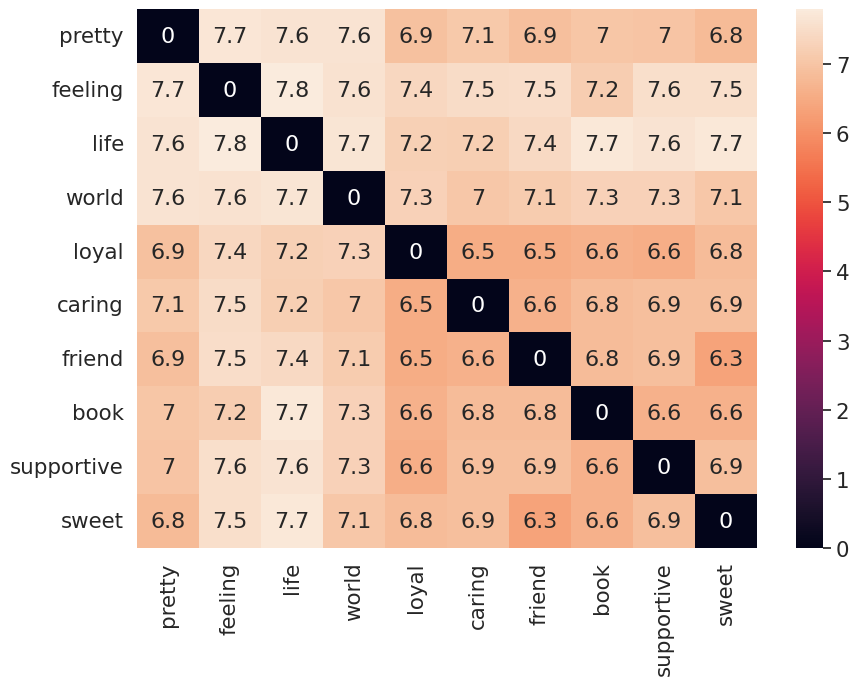

In [21]:
from scipy.spatial import distance_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

list_words = ["pretty", "feeling", "life", "world", "loyal", "caring", "friend", "book", "supportive", "sweet"]
onehot_words = encode_onehot(mapping, list_words)
list_word_embs = we_model.predict(onehot_words)

dm = distance_matrix(list_word_embs, list_word_embs, p=2)

df_dm = pd.DataFrame(dm, list_words, list_words)
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_dm, annot=True, annot_kws={"size": 16}) # font size

plt.show()